# Cross-validation and the Bootstrap

### In this lab we consider the cross-validation and bootstrap resampling methods, which are used to determine better estimates of various statistical quantities describing a given model, in comparison to doing so by using the training data set.

In [2]:
# import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd 
import math
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import *
from sklearn import datasets, linear_model
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from collections import OrderedDict

## 0. The Data Set
### In this notebook we will be analysing the 'Auto' data set, which we already came across in Chapter 2's Lab. 

In [6]:
Auto = pd.read_csv('Auto.csv', header=0, na_values='?')
Auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


### As mentioned in Chapter 2, this data set contains entries with missing values for horsepower. We should remove these before performing any statistical analysis.

In [7]:
Auto = Auto.dropna().reset_index(drop=True)
print("Size of modified data set:", Auto.shape)

Size of modified data set: (392, 9)


### Overall, we have $392$ entries for cars, each containing 9 variables. The goal is to estimate the miles per gallon ('mpg') using the remaining (appropriate) features.

## 1. The validation set approach
### We first consider fitting a simple linear regression using the feature 'horsepower' on a randomly selected half of the data set, and estimating the mean squared error (MSE) of our model using the other half as a test set.

In [14]:
# split the data into training and testing sets
np.random.seed(1)
train = np.random.choice(Auto.shape[0], 196, replace=False)
select = np.in1d(range(Auto.shape[0]), train) # dataframe selection of randomly chosen samples

### We will build five models, each one including higher order power of the 'horsepower' feature. For each model we will estimate the MSE and determine which is best.

In [15]:
max_power = 5
powers = np.arange(1, max_power + 1, 1, dtype=int)
formula = "mpg~horsepower"
for power in powers:

    # create formula
    if power > 1:
        formula = formula + "+I(horsepower **" + str(power) + ")"

    # fit the model
    model = smf.ols(formula=formula, data = Auto[select]).fit()
    # print summary of the model
    print("Model summary when including powers up to", power, ":")
    print(model.summary())

    # perform predictions using the model and estimate the MSE
    predictions = model.predict(Auto)
    squared_error_all = (Auto['mpg'] - predictions)**2
    MSE_test = squared_error_all[~select].mean()
    print("Estimated MSE:", MSE_test)
    print("\n")



Model summary when including powers up to 1 :
                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     316.4
Date:                Thu, 08 Sep 2022   Prob (F-statistic):           1.28e-42
Time:                        19:20:15   Log-Likelihood:                -592.07
No. Observations:                 196   AIC:                             1188.
Df Residuals:                     194   BIC:                             1195.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interc

### From the output we see that there is a significant decrease in the MSE only when we include the second power of 'horsepower', suggesting that there is some non-linearity in the data. Inclusion of higher-order features leads to no significant benefit as can be seen both by the relatively large $p$-values, and the small change in MSE.
### Note, however, that if we perform the same analysis using a different random seed, i.e., a different splitting of the data into training and testing data sets, we will get slightly different MSE-s. Therefore, we should better use a different approach to estimate the MSE.

## 2. Leave-One-Out Cross-Validation
### An alternative approach is to just leave out one sample of the whole data set into the validation subset, and use all others to fit the model. This is reapeated for all possible choices of the left out sample, and the average of the statistical quantities over all models are considered good estimates.

In [22]:
x = pd.DataFrame(Auto.horsepower)
y = Auto.mpg

model = LinearRegression()
k_fold = KFold(n_splits=Auto.shape[0])
test = cross_val_score(model, x, y, cv=k_fold, scoring='neg_mean_squared_error', n_jobs=-1)
print("Estimated MSE using leave-one-out cross-validation for single feature:", np.mean(test) * -1)

Estimated MSE using leave-one-out cross-validation for single feature: 24.231513517929233


Fitting model of order 1
Fitting model of order 2
Fitting model of order 3
Fitting model of order 4
Fitting model of order 5
Fitting model of order 6
Fitting model of order 7
Fitting model of order 8
Fitting model of order 9
Fitting model of order 10
Fitting model of order 11
Fitting model of order 12


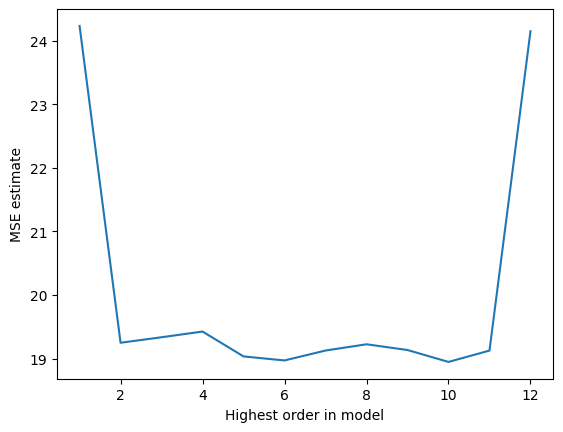

In [25]:
# To estimate the MSE for models containing different powers of horsepower we need to use the Pipeline tool
orders = np.arange(1, 13, 1, dtype=int)
MSE_values = []

for order in orders:

    print("Fitting model of order", order)
    model = Pipeline([('poly', PolynomialFeatures(degree=order)), ('linear', LinearRegression())])
    k_fold = KFold(n_splits = Auto.shape[0])
    test = cross_val_score(model, x, y, cv=k_fold, scoring='neg_mean_squared_error', n_jobs=-1)
    MSE_values.append(np.mean(test) * -1)

plt.plot(orders, MSE_values)
plt.xlabel("Highest order in model")
plt.ylabel("MSE estimate")
plt.show()

In [27]:
print("MSE for order 2:", MSE_values[1])

MSE for order 2: 19.248213124489574


### We see that the MSE barely decreases once we include orders larger than $2$. Hence, we can conclude that the best model, i.e., the one with the lowest MSE occurs for an order of $2$, and has an MSE of $\sim 19.2$.

## 3. K-fold Cross-Validation
### On large data sets it will take a long time to consider all leave-one-out cross-validation models. Hence, we can instead split the data set into larger chunks, say $K=10$, use $K-1$ of these to train the model, and test it on the remaining subset. We then take the averages over all trained models as estimates of the relevant statistical quantities. Note that this only makes sense for models more complex than a least squares linear model, since there is actually a closed-form expression for the LOOCV MSE. Nonetheless, here we saw that the best model actually includes a second order feature, so the K-fold cross-validation approach is still relevant.

Fitting model of order 1
Fitting model of order 2
Fitting model of order 3
Fitting model of order 4
Fitting model of order 5
Fitting model of order 6
Fitting model of order 7
Fitting model of order 8
Fitting model of order 9
Fitting model of order 10
Fitting model of order 11
Fitting model of order 12


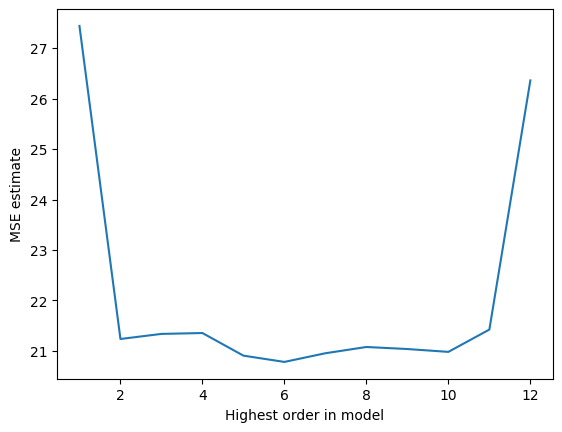

In [36]:
orders = np.arange(1, 13, 1, dtype=int)
K=10
MSE_values = []

for order in orders:

    print("Fitting model of order", order)
    model = Pipeline([('poly', PolynomialFeatures(degree=order)), ('linear', LinearRegression())])
    k_fold = KFold(n_splits = K)
    test = cross_val_score(model, x, y, cv=k_fold, scoring='neg_mean_squared_error', n_jobs=-1)
    MSE_values.append(np.mean(test) * -1)

plt.plot(orders, MSE_values)
plt.xlabel("Highest order in model")
plt.ylabel("MSE estimate")
plt.show()

### We see that the plot has an extremely similar shape to the leave-one-out case. Clearly, there is also a difference in the estimated MSE values, but the exact value of this quantity is rarely of physical importance. The important point is that we can still conclude that there is benefit to including higher order features, but only up to quadratic order. And this conclusion can be reached much fast using the $K$-fold cross validation approach, compared to the leave-one-out.

## 4. The Bootstrap
### The bootstrap method can be used to estimate errors in quantities depending on random variables. Consider for instance the following problem: we want to invest some amount of money into two assets that yield returns $X$ and $Y$. We define our investment through the parameter $\alpha$ which corresponds to the fraction of money going into the asset with return $X$. One strategy is to choose $\alpha$ such that the risk of our investment is minimum, i.e., we want to minimise $\text{Var}\left(\alpha X + (1-\alpha)Y\right)$. We can show that the optimal value for the parameter is given by the expression: $$\alpha_o=\frac{\sigma_Y^2-\sigma_{XY}}{\sigma_X^2+\sigma_Y^2-2\sigma_{XY}}.$$ However, we likely have only a data set of past returns $X$ and $Y$, from which we can only estimate the variances and covariances. The bootstrap method provides a way of providing good estimates for these quantites. We evaluate the statistical quantities for many different data sets, all created from the original data set, but containing randomly selected samples which may be repeated.
### We will demonstrate this approach using the Portforlio data set containing 100 samples for $X$ and $Y$, simulated with a value of $\alpha=0.6$.

In [37]:
Portfolio = pd.read_csv('Portfolio.csv', header=0)
print(Portfolio.head())
print(Portfolio.shape)

          X         Y
0 -0.895251 -0.234924
1 -1.562454 -0.885176
2 -0.417090  0.271888
3  1.044356 -0.734198
4 -0.315568  0.841983
(100, 2)


In [50]:
# define a function which evaluate the optimal parameter alpha for some passed data sets
def alpha(X, Y):

    covariance = np.cov(X, Y)[0,1]
    var_X = np.var(X)
    var_Y = np.var(Y)
    result = (var_Y - covariance) / (var_Y + var_X - 2 * covariance)
    return result

In [51]:
# define a function which performs the bootstrap operation
def bootstrap(data, func, no_iterations = 1000):

    values = []

    for iteration in range(no_iterations):

        # generate a random subset of the data with repetition
        subset_indices = np.random.choice(range(0, data.shape[0]), size=data.shape[0], replace=True)
        values.append(func(data.X.iloc[subset_indices], data.Y.iloc[subset_indices]))

    mean_value = np.mean(values)
    mean_error = np.std(values)
    return (mean_value, mean_error)

In [52]:
bootstrap_results = bootstrap(Portfolio, alpha)

In [56]:
print("The bootstrap estimate of alpha is " + str(round(bootstrap_results[0], 2)) + " with error " + str(round(bootstrap_results[1], 2)))

The bootstrap estimate of alpha is 0.58 with error 0.09


In [57]:
# to compare, consider the estimate when we simply use the full data set
print("The estimate when simply using the full data set is " + str(round(alpha(Portfolio.X, Portfolio.Y), 2)))

The estimate when simply using the full data set is 0.58


### Overall, we see that we get the same estimate for $\alpha$ when using the bootstrap method, despite using repeating samples, while also being able to estimate the error in this estimate. Hence, we see the power of the bootstrap approach. Common uses include error estimation for fitted parameters in models when closed form expressions for them do not exist, or if they do (linear regression) - when they rely on some assumptions about the distribution which are likely not true.